# Kaggle Mercedes Challenge

### Libraries

In [438]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Data Import

In [439]:
train = pd.read_csv('./data/train.csv')
testing = pd.read_csv('./data/test.csv')

In [440]:
train.shape

(4209, 378)

In [441]:
test.shape

(4209, 377)

### Encode categorical variables

In [442]:
## combine data for label encoding
all_data = train.append(testing)

## columns to encode
to_encode = ['X0','X1','X2','X3','X4','X5','X6','X8']
le = {}


for column in to_encode:
    le[column] = LabelEncoder()
    le[column].fit(all_data[column])
    all_data[column] = le[column].transform(all_data[column])

## resplit the data
train = all_data[0:4209]
testing = all_data[4209:].drop('y', axis=1)

## drop ID
train.drop('ID', inplace=True, axis=1)
testing_ID = testing['ID']
testing.drop('ID', inplace=True, axis=1)


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Correlation

In [443]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

In [444]:
#plot_corr(train,size=150)

### Split out validation data

In [445]:
##Dived up the data into training and validation sets

training, validation = train_test_split(train, test_size = 0.2)

training_Y = training['y']
training_X = training.drop('y', axis=1)

validation_Y = validation['y']
validation_X = validation.drop('y', axis=1)


### XGBoost

In [446]:
##Create train and validate DMatrix
trainingXGB = xgb.DMatrix(training_X, label=training_Y)
validateXGB = xgb.DMatrix(validation_X)



### Finding best hyperparameters

In [ ]:
##Set up crossvalidation and build model to test.  
ind_params = {'nthread':3}
cv_params = {'max_depth':[2],
             'min_child_weight':[17],
             'gamma':[0],
             'subsample':[.9],
             'colsample_bytree':[.7],
             'learning_rate':[.3], 
             'n_estimators':[17],
             'reg_alpha':[0]
              }
##Build optimized model with GridSearch
model_xgb = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                         cv_params, 
                         cv=10, 
                         n_jobs=3,
                         verbose=100,
                         scoring='neg_mean_squared_error')

model_xgb.fit(training_X, training_Y)

best_params = model_xgb.best_params_

In [422]:
best_params

{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.3,
 'max_depth': 2,
 'min_child_weight': 17,
 'n_estimators': 22,
 'reg_alpha': 0,
 'subsample': 0.9}

Looking for best number of rounds

In [ ]:
##Tune booster rounds

cvresult = xgb.cv(best_params, 
                  trainingXGB, 
                  nfold=10,  
                  num_boost_round=10000, 
                  early_stopping_rounds=50,
                  metrics='rmse',
                  verbose_eval=True)




best_params['n_estimators'] = len(cvresult)

In [447]:
model_xgb = xgb.train(best_params,trainingXGB, num_boost_round = best_params['n_estimators'])
predY_xgb = model_xgb.predict(validateXGB)

In [449]:
r2_score(validation_Y, predY_xgb)

0.5784671573437925

In [419]:
feat_imp = model_xgb.get_score(importance_type='gain')
importance = pd.DataFrame.from_dict(feat_imp, orient='index')
importance.columns = ['importance']
importance.sort_values(by='importance', ascending=False, inplace=True)

top10 = importance.index[:10]


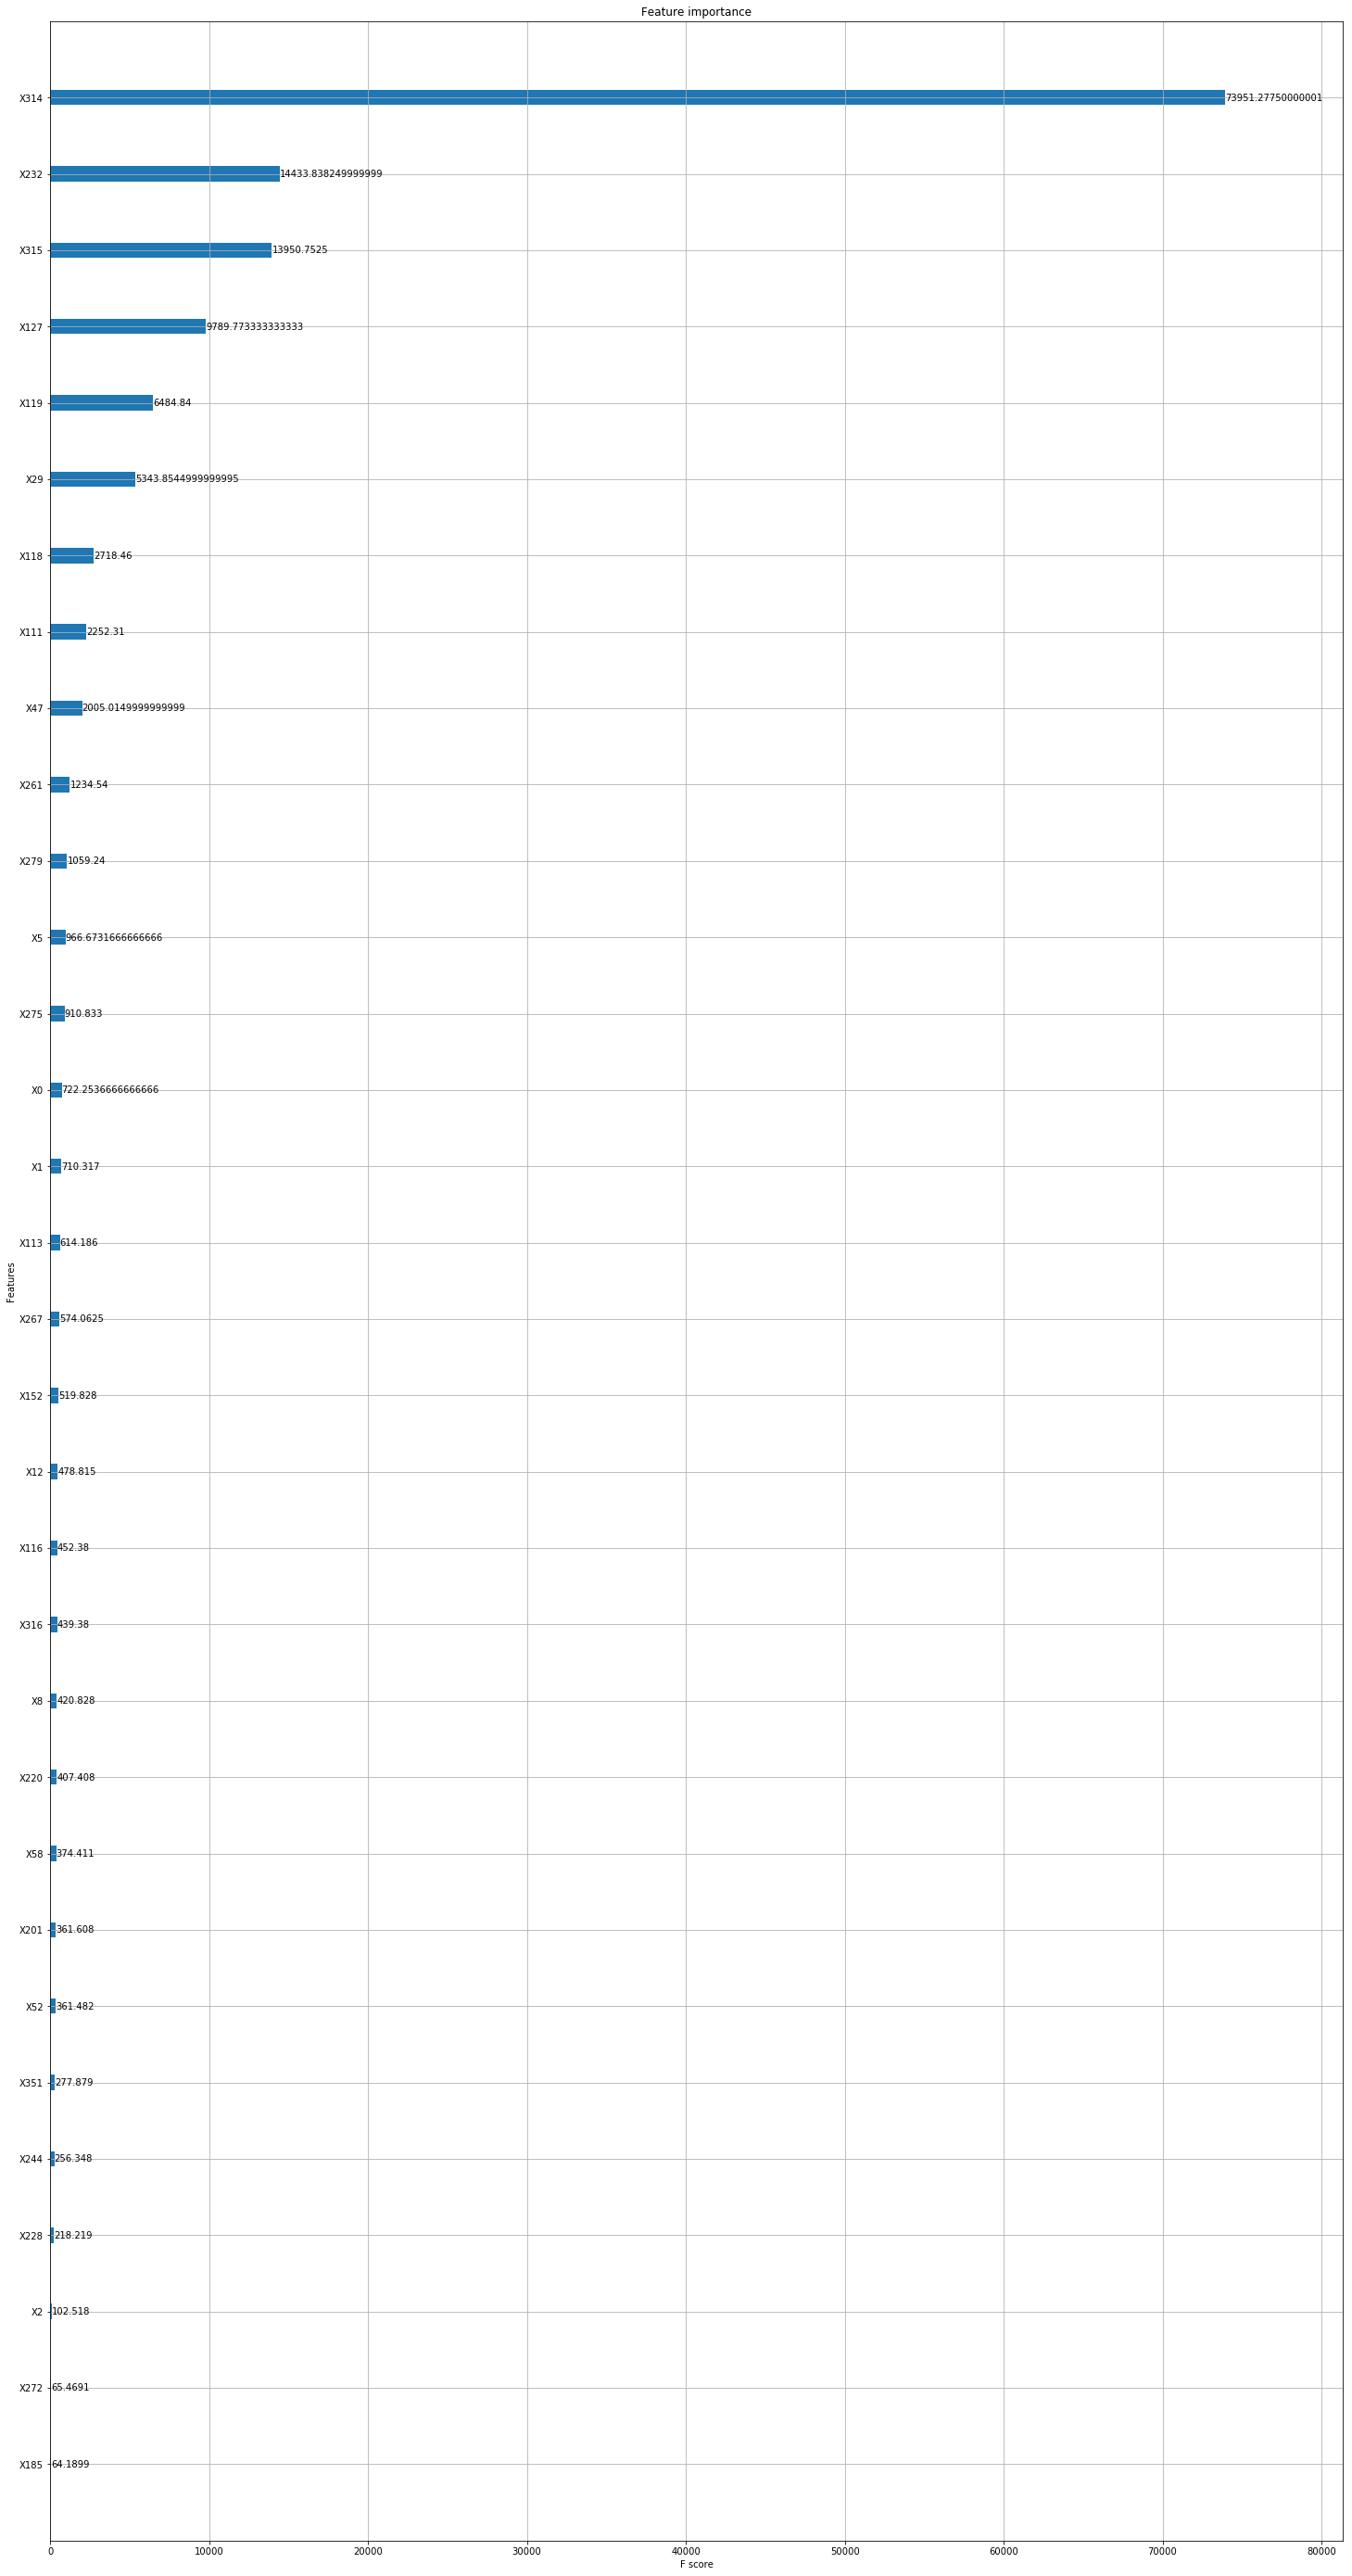

In [420]:
fig, ax = plt.subplots(figsize=(25, 50))
xgb.plot_importance(model_xgb, ax=ax, importance_type='gain')



###  neural network

In [ ]:
rows, features = training_X.shape

model_nn = Sequential()
model_nn.add(Dense(features, input_dim=features, activation='relu', bias_initializer='RandomNormal'))
#model_nn.add(Dropout(.6,))
model_nn.add(Dense(50, activation='relu', bias_initializer='RandomNormal'))
#model_nn.add(Dropout(.6,))
model_nn.add(Dense(1, activation='linear', bias_initializer='RandomNormal'))

model_nn.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

In [ ]:
weight_file = 'bestweights'
callbacks = [EarlyStopping(monitor='val_loss',patience=20, verbose=0),
            ModelCheckpoint(weight_file, verbose=0, save_best_only=True)]
model_nn.fit(training_X, training_Y, epochs=100000, batch_size=32, validation_data=(validation_X, validation_Y), callbacks=callbacks)

### Final and submission

In [ ]:
train_Y = train['y']
train_X = train.drop('y',axis=1)

testing_final = testing.values

#### nerual net sub

In [ ]:
rows, features = train_X.shape

model_nn_final = Sequential()
model_nn_final.add(Dense(features, input_dim=features, activation='relu', bias_initializer='RandomNormal'))
#model_nn_final.add(Dropout(.6,))
model_nn_final.add(Dense(50, activation='relu', bias_initializer='RandomNormal'))
model_nn_final.add(Dense(1, activation='linear', bias_initializer='RandomNormal'))

model_nn_final.compile(loss='mean_squared_error', optimizer='adam')

model_nn_final.load_weights(weight_file, by_name=False)

predY_nn_final = model_nn.predict(testing_final, batch_size=128)

In [ ]:
submission_nn = pd.DataFrame()
submission_nn['ID'] = testing['ID']
submission_nn['y'] = predY_nn_final


sub_file_nn = 'submission-nn.csv'
submission_nn.to_csv(sub_file_nn, index=False)

#### xgboost sub

In [421]:
train_final_Y = train['y']
train_final_X = train.drop('y',axis=1)
#train_final_X = train[top10]
#testing_final = testing[top10]
testing_final = testing

trainXGB = xgb.DMatrix(train_final_X, label=train_final_Y)
testingXGB = xgb.DMatrix(testing_final)

model_xgb_final = xgb.train(best_params,trainXGB, num_boost_round = best_params['n_estimators'])

predY_xgb_final = model_xgb_final.predict(testingXGB)



submission_xgb = pd.DataFrame()
submission_xgb['ID'] = testing_ID
submission_xgb['y'] = predY_xgb_final


sub_file_xgb = 'submission-xgb.csv'
submission_xgb.to_csv(sub_file_xgb, index=False)